In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from collections import Counter
from fa2 import ForceAtlas2
from DataCleaningFunctions import DataCleaner, DataCollection, DataProcesser
import os
import json
import os
import re
import requests
from urllib.parse import quote, unquote

In [3]:
data = pd.read_json('df_movies.json',orient='table')
data = data.reset_index(drop=True)

In [5]:
def remove_comments(text):
    """
    Remove all comments from the wikicontent, so only the plot remains
    """
    return re.sub(r'<!--.*?-->', '', text)

def clean_filename(filename):
    """
    Replace non-alphanumeric characters (except underscores) with underscores
    """
    return re.sub(r'[^a-zA-Z0-9_]', '_', filename)

def get_wikipedia_content(title):
    """
    For the #redirect use these params instead.
    """
    base_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "revisions",
        "rvprop": "content"}
    
    response = requests.get(base_url, params=params)
    data = response.json()
    page = next(iter(data["query"]["pages"].values()))
    content = page.get("revisions", [{}])[0].get("*", "")
    return content

def contains_redirect(content):
    """
    In case of the lower case #REDIRECT
    """
    return "#redirect" in content.lower()

def resolve_redirects(content):
    """
    In case of #redirect/#REDIRECT in the extracted wikicontent.
    """
    while contains_redirect(content):
        # Extract the target page from the redirect content
        target_title = content.split("[[", 1)[-1].split("]]")[0]
        content = get_wikipedia_content(target_title)
    return content

def get_plot_text(wiki_content):
    """
    Extract only the plot text from the found wikicontent.
    """
    wiki_content_without_comments = remove_comments(wiki_content)
    plot_section_match = re.search(r'==\s*Plot\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    plot_section_match
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Plot summary\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Summary\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Story\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Synopsis\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Premise\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Plot\s*==\s*(.*?)(?==\s*[^=]|$)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    plot_section = plot_section_match.group(1) if plot_section_match else None
    return plot_section


In [8]:
def get_movie_plots(data_movie_artist):
    no_plot_counter = 0

    for index, row in data_movie_artist.iterrows():
        title = row['Title']
        wikiname = row['Hyperref']
        genre = row['Genre']
        year = row['Year']

        # Remove plots manually that are in different language with no plots (Thriller)
        if any(data_movie_artist[data_movie_artist["Title"].isin(["Life Is an Art", "A Morass", "Blind Turn", "Requiem pour une tueuse", "She and She", "American Sunset", "Espion(s)"])]["Hyperref"] == wikiname):
            plot_text = "No plot"
            no_plot_counter += 1
            print(f"dropped {title}")
            continue

        # Remove plots manually that are in a different language with no plots (Action)
        if any(data_movie_artist[data_movie_artist["Title"].isin(["Sheenogai", "Vampire Warriors", "Bangkok Revenge", "My Kingdom", "Wild 7", "San Andreas Quake"])]["Hyperref"] == wikiname):
            plot_text = "No plot"
            no_plot_counter += 1
            print(f"dropped {title}")
            continue

        try:
            # Make the request
            baseurl = "https://en.wikipedia.org/w/api.php?"  # the wiki API
            params = {
                "action": "query",
                "prop": "revisions",
                "rvprop": "content",
                "format": "json",
                "titles": unquote(wikiname)
            }

            wikitext = requests.get(baseurl, params=params)
            wikijson = wikitext.json()
            page_id = next(iter(wikijson["query"]["pages"]))
            revisions = wikijson["query"]["pages"][page_id].get("revisions", [])

            if not revisions:
                raise KeyError("No revisions key")

            wiki_content = revisions[0]["*"]
            # If the wiki page is a redirect do
            if "#REDIRECT" or "#redirect" in wiki_content:
                wiki_content = resolve_redirects(wiki_content)
            plot_section = get_plot_text(wiki_content)

            # Extract the clean plot text without comments and hyperlinks
            if plot_section:
                plot_text = remove_comments(plot_section)
                # Remove hyperlinks
                plot_text = re.sub(r'\[\[([^|\]]*?\|)?([^\]]*?)\]\]', r'\2', plot_text)
            else:
                plot_text = "Plot not found."
                no_plot_counter += 1
                print(f"Plot not found for {genre}/{year}/{title}")

            # Create folders based on genre and subfolders based on the year
            genre_folder = clean_filename(genre)
            year_folder = clean_filename(str(year))
            os.makedirs(f'{genre_folder}/{year_folder}', exist_ok=True)

            # Save plot text in a .txt file
            with open(os.path.join(genre_folder, year_folder, f'{clean_filename(title)}.txt'), 'w', encoding='utf-8') as f:
                f.write(plot_text)

        except KeyError as e:
            print(f"Error processing {wikiname}: {e}")
            plot_text = "No plot"
            no_plot_counter += 1
            print(f"dropped {title}")
            continue
        
    print(no_plot_counter)


In [9]:
get_movie_plots(data)

Plot not found for Thriller/2020/The Retreat
Plot not found for Thriller/2021/Akshara
Plot not found for Thriller/2021/Lockdown
Plot not found for Action/2022/Salaar
Error processing /w/index.php?title=Golden_Slumber_(2010_film)&action=edit&redlink=1: 'No revisions key'
dropped Golden Slumber yoshihiro nakamura
dropped Life Is an Art
dropped A Morass
dropped Blind Turn
dropped Requiem pour une tueuse
Plot not found for Horror/2013/The Supernatural Events on Campus
Plot not found for Horror/2014/Bloody Doll
Plot not found for Mix/2014/Bugs
Plot not found for Thriller/2014/The Deathday Party
Plot not found for Horror/2014/Double Exposure
Plot not found for Thriller/2014/The Eighth House
Plot not found for Horror/2014/Flower's Curse
Plot not found for Horror/2014/Lonely Island
Plot not found for Horror/2014/Monsterz
Plot not found for Mix/2014/Mystery
dropped She and She
Plot not found for Horror/2014/The Haunted Cinema
Plot not found for Mix/2014/Tomb Robber
Plot not found for Thriller/2

### **NLP analysis**

First, an initial analysis of the text plots distribution, then datacleaning and after analysis on the happiness score of the text plots

##### Initial plotting of distribution by genre and year

> Count how many with plots within each genre

In [25]:
def count_txt_files(root_folder, genres):
    # Initialize an empty dictionary to store the counts
    genre_counts = {}

    # Iterate over the specified genres
    for genre in genres:
        genre_path = os.path.join(root_folder, genre)

        # Check if the genre folder exists
        if os.path.exists(genre_path) and os.path.isdir(genre_path):
            genre_counts[genre] = {}  # Initialize a sub-dictionary for the genre

            # Traverse through the year subfolders
            for year in os.listdir(genre_path):
                year_path = os.path.join(genre_path, year)

                # Check if it's a directory
                if os.path.isdir(year_path):
                    # Count the occurrences of "Plot not found." and longer texts
                    not_found_count = 0
                    longer_text_count = 0

                    # Traverse through the .txt files in the year subfolder
                    for file_name in os.listdir(year_path):
                        if file_name.endswith('.txt'):
                            file_path = os.path.join(year_path, file_name)

                            with open(file_path, 'r', encoding='utf-8') as file:
                                content = file.read()

                                if content == 'Plot not found.':
                                    not_found_count += 1
                                elif len(content) > 0:  # Check if the text is longer than 0 characters
                                    longer_text_count += 1

                    # Store the counts in the sub-dictionary for the year
                    genre_counts[genre][year] = {
                        'Plot not found': not_found_count,
                        'Longer text': longer_text_count
                    }

    return genre_counts

# Example usage with specified genres
root_folder = r'..\Cinemartist-Networks-and-Interactions'
specified_genres = ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Horror', 'Mix', 'Science_Fiction', 'Thriller']
result = count_txt_files(root_folder, specified_genres)
print(result)


{'Action': {'2000': {'Plot not found': 1, 'Longer text': 21}, '2001': {'Plot not found': 3, 'Longer text': 21}, '2002': {'Plot not found': 4, 'Longer text': 23}, '2003': {'Plot not found': 3, 'Longer text': 30}, '2004': {'Plot not found': 3, 'Longer text': 30}, '2005': {'Plot not found': 3, 'Longer text': 32}, '2006': {'Plot not found': 1, 'Longer text': 33}, '2007': {'Plot not found': 2, 'Longer text': 27}, '2008': {'Plot not found': 3, 'Longer text': 36}, '2009': {'Plot not found': 1, 'Longer text': 42}, '2010': {'Plot not found': 0, 'Longer text': 55}, '2011': {'Plot not found': 6, 'Longer text': 44}, '2012': {'Plot not found': 1, 'Longer text': 39}, '2013': {'Plot not found': 4, 'Longer text': 46}, '2014': {'Plot not found': 3, 'Longer text': 34}, '2015': {'Plot not found': 3, 'Longer text': 27}, '2016': {'Plot not found': 1, 'Longer text': 26}, '2017': {'Plot not found': 1, 'Longer text': 31}, '2018': {'Plot not found': 3, 'Longer text': 30}, '2019': {'Plot not found': 2, 'Longer 

> Display the distribution by year decade range of how many plots are found and how many plots have not been found.

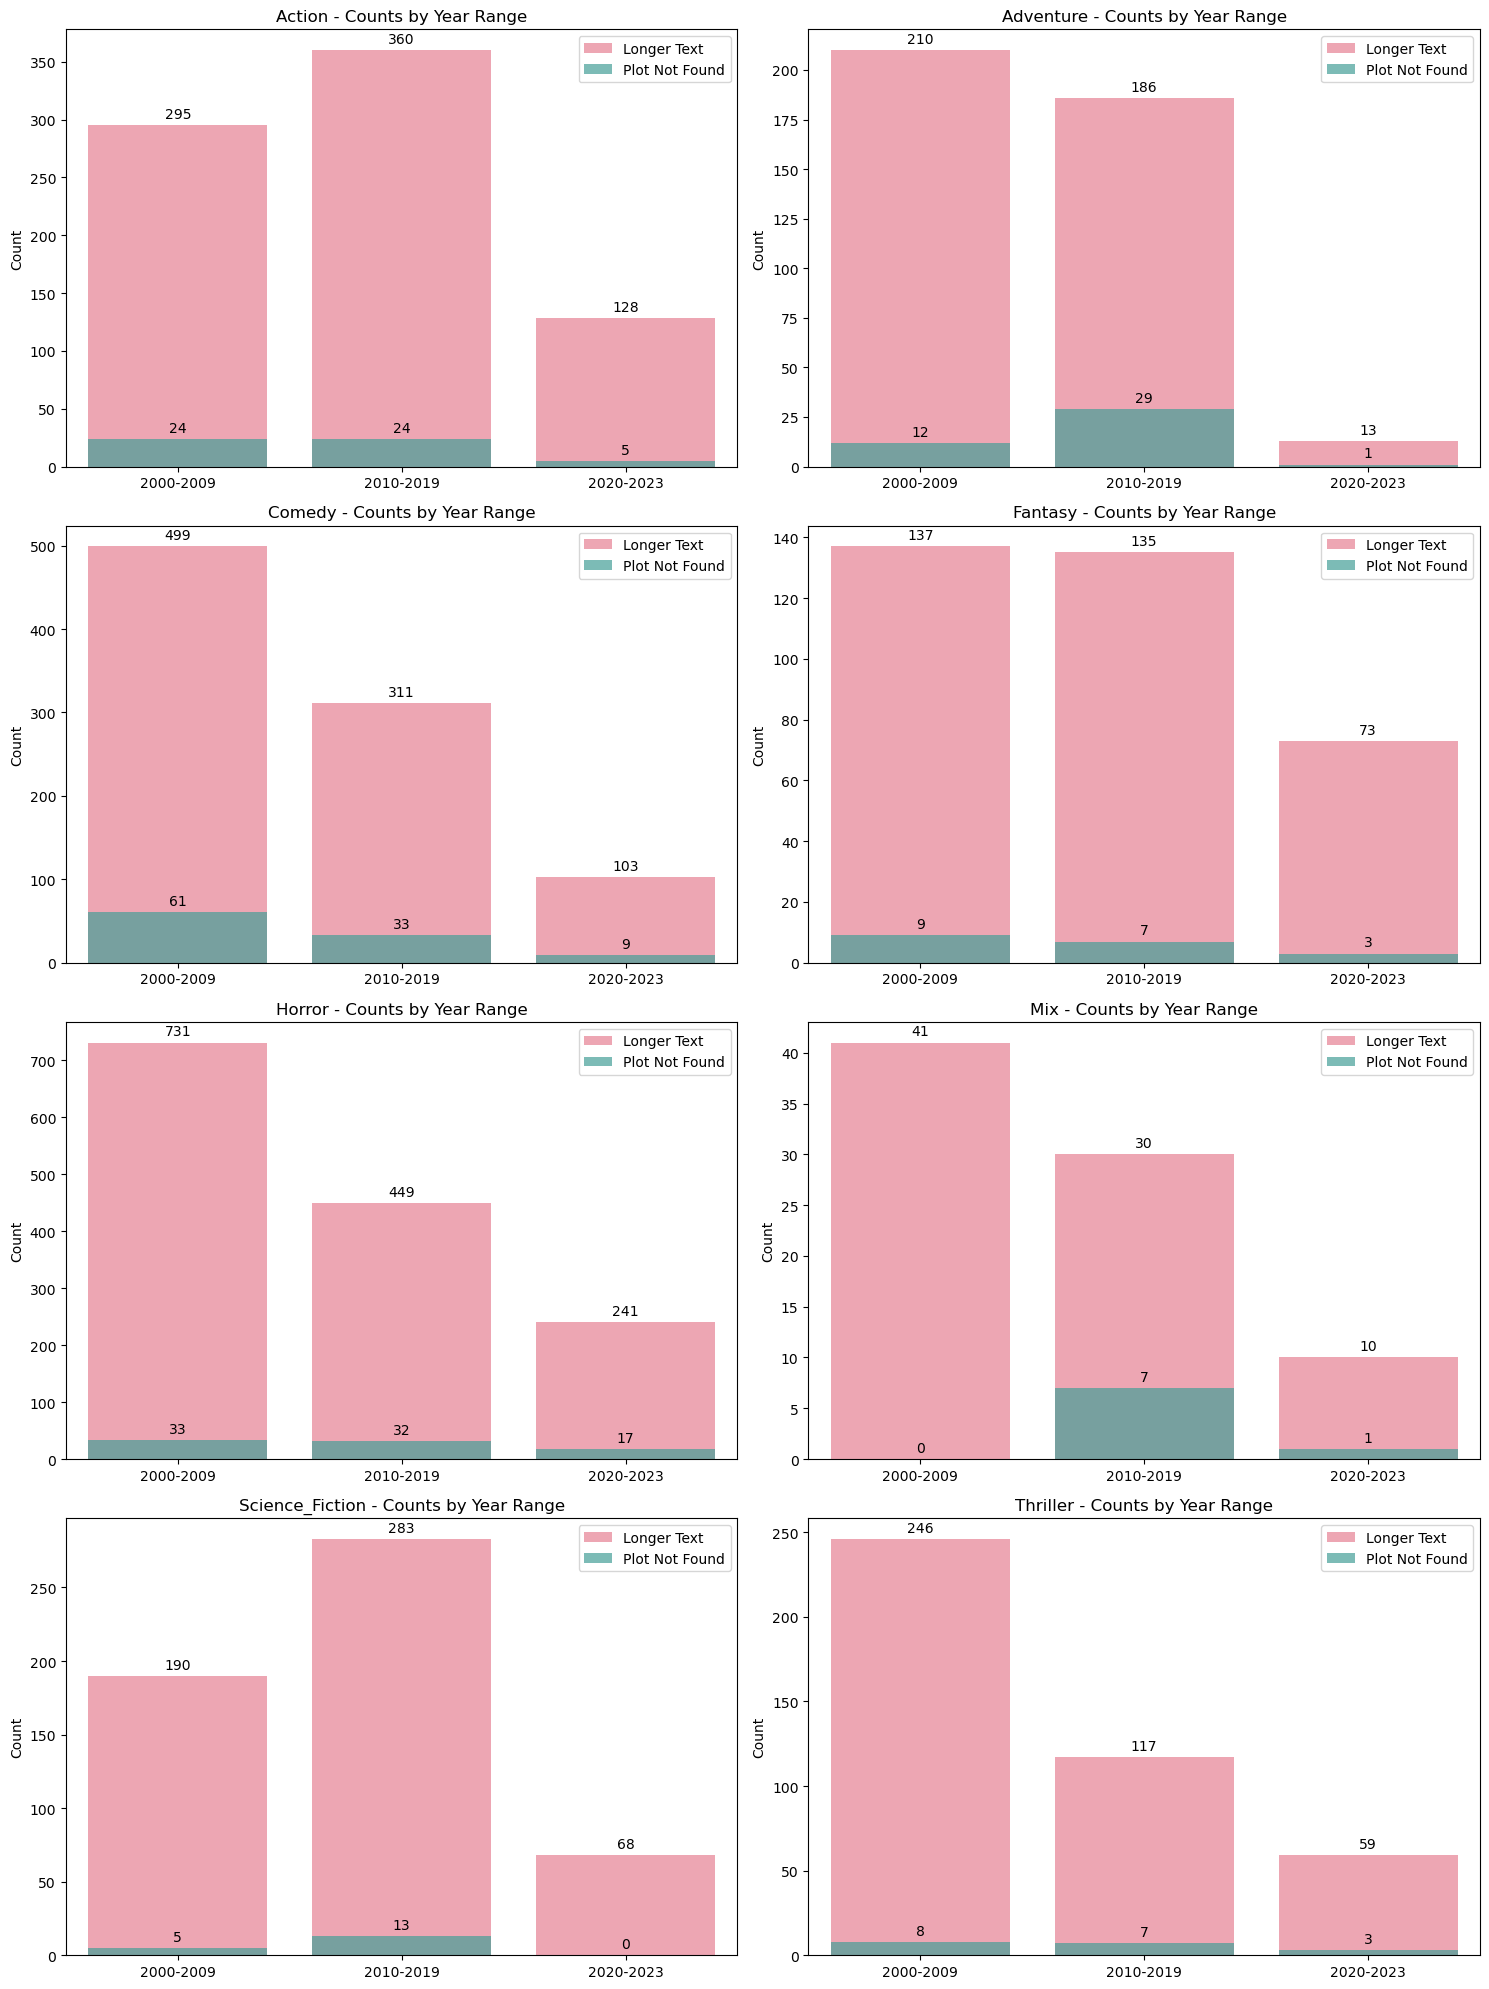

In [57]:
def aggregate_counts_by_range(year_counts, start, end, category):
    return sum(count[category] for year, count in year_counts.items() if start <= int(year) <= end)

def plot_histograms_seaborn(genre_counts):
    # Set up subplots for each genre in a 4x2 grid
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))

    # Define the year ranges
    ranges = [(2000, 2009), (2010, 2019), (2020, 2023)]

    # Define a color palette
    colors = sns.color_palette("husl", 2)  # Using the 'husl' color palette with 2 colors

    # Iterate over genres
    for i, (genre, year_counts) in enumerate(genre_counts.items()):
        # Aggregate counts for each range
        counts_longer_text = [aggregate_counts_by_range(year_counts, start, end, 'Longer text') for start, end in ranges]
        counts_plot_not_found = [aggregate_counts_by_range(year_counts, start, end, 'Plot not found') for start, end in ranges]

        # Plot bar plot using Seaborn
        row, col = divmod(i, 2)
        bar_width = 0.35
        opacity = 0.7

        # Adjust x-coordinates for the bars
        x = range(len(ranges))
        sns.barplot(x=[val - bar_width/2 for val in x], y=counts_longer_text, color=colors[0], alpha=opacity, ax=axs[row, col], label='Longer Text')
        sns.barplot(x=[val + bar_width/2 for val in x], y=counts_plot_not_found, color=colors[1], alpha=opacity, ax=axs[row, col], label='Plot Not Found')

        axs[row, col].set_xticks(x)
        axs[row, col].set_xticklabels([f'{start}-{end}' for start, end in ranges])
        axs[row, col].set_title(f'Genre: {genre} - Counts by Year Range')
        axs[row, col].set_ylabel('Count')
        axs[row, col].legend()

        # Add annotations above each bar
        for bar, count in zip(axs[row, col].patches, counts_longer_text + counts_plot_not_found):
            axs[row, col].annotate(count, 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Example usage with the previously obtained genre_counts
plot_histograms_seaborn(result)


##### Datacleaning on text plots: Lemmatizing, tokenize, remove stopwords

In [55]:
from nltk.corpus import PlaintextCorpusReader # from book
import nltk
import string
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [56]:
# Initialize NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') # Need this to avoid error

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Sorting alphabetically
files_list = df_rappers
# Making the rapper corpus
corpus_root = 'rapper_texts'
wordlists = PlaintextCorpusReader(corpus_root, '.*\.txt')
print(len(wordlists.fileids()))
#wordlists.fileids()

In [ ]:
wiki_rapper_text = nltk.Text(wordlists.words())
len(wiki_rapper_text)

In [ ]:
wiki_rapper_text.concordance("glad")

In [ ]:
# A collocation is a sequence of words that occur together unusually often
wiki_rapper_text.collocations()

##### From week 7 TF to make word clouds

In [ ]:
# Function to make all text lower case and remove punctuation
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Tokenize the content into words
    words = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in words if word not in string.punctuation]
    # Lemmatize the words
    words = [lemmatizer.lemmatize(word, wordnet.VERB) for word in words]  # You can specify the part of speech if needed
    return words

# Function to tokenize text and create a term frequency list
def tokenize_and_count_frequency(folder_path):
    term_frequency = Counter()
    
    # Iterate through all .txt files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                # Preprocess the content
                words = preprocess_text(content)
                # Update term frequency count
                term_frequency.update(words)

    return term_frequency

In [ ]:
# Path to the 'east_texts' and 'west_texts' folders
east_folder_path = 'east_texts'
west_folder_path = 'west_texts'

# Tokenize and count term frequency for each folder
east_TF = tokenize_and_count_frequency(east_folder_path)
west_TF = tokenize_and_count_frequency(west_folder_path)

In [ ]:
# Print the term frequency lists
print("East Term Frequency:")
print(east_TF)
print(len(east_TF))

print("\nWest Term Frequency:")
print(west_TF)
print(len(west_TF))

Word clouds install

In [ ]:
import os
from os import path
from wordcloud import WordCloud

##### Check for all plots without plots

In [10]:

def get_movie_title_from_file(file_path):
    with open(file_path, 'r') as file:
        # Assuming the title is on the first line
        title = file.readline().strip()
    return title

def search_for_text_in_files(root_folder, target_text):
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith(".txt"):
                file_path = os.path.join(foldername, filename)
                with open(file_path, 'r') as file:
                    content = file.read()
                    if target_text in content:
                        title = get_movie_title_from_file(file_path)
                        print(f'Text "{target_text}" found in {title} ({file_path})')


In [11]:

# Replace 'your_root_folder' with the path to the root folder you want to start the search from
root_folder = '..\Cinemartist-Networks-and-Interactions'
target_text = 'Plot not found'

search_for_text_in_files(root_folder, target_text)


Text "Plot not found" found in Plot not found. (..\Cinemartist-Networks-and-Interactions\Action\2000\Sugo_ng_Tondo.txt)
Text "Plot not found" found in Plot not found. (..\Cinemartist-Networks-and-Interactions\Action\2001\Alas_Dose.txt)
Text "Plot not found" found in Plot not found. (..\Cinemartist-Networks-and-Interactions\Action\2001\Hindi_Sisiw_ang_Kalaban_Mo.txt)
Text "Plot not found" found in Plot not found. (..\Cinemartist-Networks-and-Interactions\Action\2001\Masikip_Na_ang_Mundo_Mo__Labrador.txt)
Text "Plot not found" found in Plot not found. (..\Cinemartist-Networks-and-Interactions\Action\2002\Alive.txt)
Text "Plot not found" found in Plot not found. (..\Cinemartist-Networks-and-Interactions\Action\2002\Ang_Alamat_ng_Lawin.txt)
Text "Plot not found" found in Plot not found. (..\Cinemartist-Networks-and-Interactions\Action\2002\Batas_ng_Lansangan.txt)
Text "Plot not found" found in Plot not found. (..\Cinemartist-Networks-and-Interactions\Action\2002\Mano_Mano_2__Ubusan_ng_Laka

##### further

In [12]:
data[data['Title']== "American Pie Presents: The Naked Mile"]

,Title,Director,Cast,Country,Genre,Year,Hyperref
2258,American Pie Presents: The Naked Mile,joe nussbaum,"john white,jessy schram,steve talley,christoph...",united states,Comedy,2007,Joe_Nussbaum


In [37]:
unquote(wikiname)

'Samaritan'

In [93]:
# Make the request
from urllib.parse import quote, unquote

baseurl = "https://en.wikipedia.org/w/api.php?"  # the wiki API
wikiname = "Boarding_Gate"

params = {
    "action": "query",
    "prop": "revisions",
    "rvprop": "content",
    "format": "json",
    "titles": unquote(wikiname)
}
wikitext = requests.get(baseurl, params=params)
wikijson = wikitext.json()
page_id = next(iter(wikijson["query"]["pages"]))


In [94]:
unquote(wikiname)

'Boarding_Gate'

In [ ]:
# Check if "revisions" key is present
revisions = wikijson["query"]["pages"][page_id].get("revisions", [])
if not revisions:
    raise KeyError("No revisions key")

wiki_content = revisions[0]["*"]


wiki_content_without_comments = remove_comments(wiki_content)
print(wiki_content_without_comments)
plot_section_match = re.search(r'==\s*Plot\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
plot_section_match
if plot_section_match is None:
    plot_section_match = re.search(r'==\s*Plot summary\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
if plot_section_match is None:
    plot_section_match = re.search(r'==\s*Synopsis\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
if plot_section_match is None:
    plot_section_match = re.search(r'==\s*Premise\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
if plot_section_match is None:
    plot_section_match = re.search(r'==\s*Plot\s*==\s*(.*?)(?==\s*[^=]|$)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
plot_section = plot_section_match.group(1) if plot_section_match else None


In [100]:
plot_section

''

In [ ]:
wiki_text = "Your Wikipedia text here"

pattern = r'==\s*Plot\s*==\s*(.*?)(?==\s*[^=]|$)'

matches = re.search(pattern, wiki_text, re.DOTALL)
if matches:
    plot_content = matches.group(1).strip()
    print(plot_content)

In [101]:

if plot_section == '':
    print('true')
    if "#REDIRECT" or "#redirect" in wiki_content:
        print("yes")
        wiki_content = resolve_redirects(wiki_content)
        wiki_content_without_comments = remove_comments(wiki_content)
        plot_section_match = re.search(r'==\s*Plot\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
        plot_section_match
        if plot_section_match is None:
            plot_section_match = re.search(r'==\s*Plot summary\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
        if plot_section_match is None:
            plot_section_match = re.search(r'==\s*Synopsis\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
        if plot_section_match is None:
            plot_section_match = re.search(r'==\s*Premise\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)


true
yes


In [102]:
plot_section = plot_section_match.group(1) if plot_section_match else None
plot_section

''